# Parameterizing the LHCb RICH system using the pidgan's `GAN` algorithm

**Author:** [mbarbetti](https://github.com/mbarbetti)

**Date created:** 12/10/2023

**Last modified:** 13/10/2023

**Description:** This tutorial demonstrates how to parameterize the high-level response of the LHCb RICH system using a Generative Adversarial Network (GAN) [[1](https://arxiv.org/abs/1406.2661)]. The code is written using the [pidgan](https://github.com/mbarbetti/pidgan) package that relies on TensorFlow and Keras as backends.

## Introduction

### What is LHCb?

The [**LHCb experiment**](https://lhcb-outreach.web.cern.ch) has been originally designed to study rare decays of particles containing $b$ and $c$ quarks produced at the Large Hadron Collider (LHC). The LHCb detector, shown in the background of the following photo, is a single-arm forward spectrometer covering the pseudorapidity range of $2 < \eta < 5$. The detector includes:

- **Tracking system** - used for high-precision measurements of the momentum of charged particles and the position of the primary vertices
- **Particle Identification (PID) system** - used to distiguish different species of traversing particles (i.e., muons, pions, kaons, protons)

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/lhcb.jpeg" width="800"/>
</div>

#### The RICH detectors

The LHCb PID system counts two ring-imaging Cherenkov ([RICH](https://lhcb-outreach.web.cern.ch/detector/rich-detectors/)) detectors whose response allows to separate different types of charged hadrons (e.g., pions, kaons, protons) using the [Cherenkov radiation](https://en.wikipedia.org/wiki/Cherenkov_radiation) of the traversing particles. The Cherenkov radiation produces circles (shown in the following left figure) within the RICH detector whose size is related to the mass of the emitting particle. Reconstructing such circles allow to distinguish particles accordingly to their species (highlighted in the following right figure).

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/rich-response.png" height="300"/>
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/rich-performance.png" height="300"/>
</div>

### What are GANs?

Generative Adversarial Networks [[1](https://arxiv.org/abs/1406.2661)] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  **Discriminator network** ($D$) - trained by a classification task to separate the generator output from the reference dataset
* **Generator network** ($G$) - trained by a simulation task to reproduce the reference dataset trying to fake the discriminator

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1](https://arxiv.org/abs/1406.2661)].

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/gan-scheme.png" width="800"/>
</div>

#### Mathematical details

The generator $G(z)$, fed by elements $z$ sampled according to a known distribution $p_z$ (typically gaussian), maps the **latent space** $\mathcal{Z}$ to the reference dataset $\mathcal{X}$, inducing a distribution $p_\rm{gen}$ trained to match with the target distribution $p_\rm{ref}$. The discriminator $D(x)$ outputs a single scalar, readable as the **probability** that $x$ comes from the reference dataset rather than $G$. Hence, the optimization problem corresponds to train $D$ to maximize the probability of correct labelling, and simultaneously training $G$ to minimize $\log(1 - D(G(z)))$.

Defining the **loss function** $\mathcal{L}_{\rm{GAN}}$ as follows

<center>$\mathcal{L}_{\rm{GAN}} (\theta_d, \theta_g) = \mathbb{E}_{x \sim p_\rm{ref}} \left[ \log{D_{\theta_d}(x)} \right] + \mathbb{E}_{z \sim p_\rm{z}} \left[ \log(1 - D_{\theta_d}(G_{\theta_g}(z))) \right]$</center>

the _minimax game_ can be written in this form:

<center>$\displaystyle{\min_G \, \max_D \, \mathcal{L}_{\rm{GAN}} (\theta_d, \theta_g)}$</center>

A unique solution exists, with $G$ recovering the reference distribution $p_\rm{ref}$ and $D$ equal to 1/2 everywhere [[1](https://arxiv.org/abs/1406.2661)].

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator _may collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**)
* the two players _may oscillate_ during training rather than converging to the [**Nash equilibrium**](https://en.wikipedia.org/wiki/Nash_equilibrium)
* if _imbalance_ between the two players occurs, then the system is incapable of learning at all

All these drawbacks result from the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), namely the lack of information for the update of the $G$ parameters. This is due to the saturation of the $D$ that is so good in distinguishing the origin of the two samples that no errors remain to the $G$ to improve the generated space. To fix the problem, one can add _continuous noise_ to both $D$ and $G$. This trick allows to learn thanks to a non-zero gradient [[2](https://arxiv.org/abs/1701.04862)].

#### Using input conditions

Feeding the generator with additional information besides the latent space sample allows to **conditionate** its output. In particular, it's sufficient to concatenate the conditional features $x$ to the random noise $z$ passed as input to $G$ to make it able to take into account this information [[3](https://arxiv.org/abs/1411.1784)]: $y_{\rm{gen}}(x) = G(x, z)$. Obviously, to preserve the capability to learn through the minimax game, also the discriminator must be fed by the additional features $x$, simply concatenating them to either elements of the reference sample or of the generated space [[3](https://arxiv.org/abs/1411.1784)]: $D(x, y)$ with $y \in \{y_{\rm{ref}}, y_{\rm{gen}}\}$.

## Tutorial

The aim of this tutorial is to build a parameterization of the LHCb RICH detectors. Since we expect that the high-level response of the RICH system only depends on the kinematics of the traversing particles and the detector occupancy, the former can be parameterized training a **GAN model** properly conditioned [[3](https://arxiv.org/abs/1411.1784), [4](https://arxiv.org/abs/1905.11825)]. The pidgan package provides several GAN [`algorithms`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/algorithms) implementing some of the most used tricks presented in the literature to stablize their training [[1](https://arxiv.org/abs/1406.2661), [2](https://arxiv.org/abs/1701.04862), [5](https://arxiv.org/abs/1606.03498)]. The pidgan's [`players`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/players), namely the generator and discriminator network, are designed to be trained taking conditions as input. In this notebook we will see how to build a model for the RICH system using the pidgan's [`GAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/GAN.py) algorithm.

### Install

The first step is to install the [pidgan](https://github.com/mbarbetti/pidgan) package and some other ones that are typically needed in machine learning applications to High Energy Physics (i.e., uproot, scipy, scikit-learn, matplotlib).

In [1]:
%%capture
!pip install pidgan[lamarr]

Now, let's verify the correct installation of pidgan printing its version:

In [2]:
import pidgan

pidgan.__version__

'0.0.5'

In case you're running this notebook on a machine equipped with a GPU, let's also verify the correct installation of TensorFlow:

In [3]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")  # outputs a non-empty list in case of GPU equipped

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Finally, we just have to import all the modules that we will use in the following code cells:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.preprocessing import QuantileTransformer

### Data loading

The data needed for this tutorial is provided through a CSV file downloadable from the [pidgan-notebooks](https://github.com/mbarbetti/pidgan-notebooks) repository.

**Disclaimer:** The data results from a toy model of the LHCb RICH system combining its high-level response when traversed by a set of long-lived charged particles, namely muons, pions, kaons and protons.

The CSV file contains 250000 instances, 4 input features and 4 output features. Let's import the data as a pandas' DataFrame:

In [5]:
url = "https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/data/pidgan-toy-data.csv"
data = pd.read_csv(url)

data.describe()

,P,ETA,nTracks,trackcharge,RichDLLe,RichDLLmu,RichDLLk,RichDLLp
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,19112.579988,3.362231,180.468471,0.021152,-8.959810,-1.853031,-3.614234,-3.626358
std,22610.408265,0.770202,91.626085,0.999778,16.090133,11.512878,28.799922,28.006328
min,3000.090800,1.800331,9.000999,-1.000000,-140.804340,-110.494200,-149.289830,-149.591670
25%,5970.525000,2.749856,116.000000,-1.000000,-12.259203,-3.784543,-16.768035,-18.402633
50%,10983.800000,3.340136,164.000000,1.000000,-3.499332,-0.634627,1.748902,1.705883
75%,22392.768000,3.949773,228.000000,1.000000,-0.179516,0.651420,14.155344,15.179315
max,199837.420000,5.434650,739.993000,1.000000,58.021923,106.868935,120.245310,110.364006


We expect that the response of the RICH detectors only depends on the **kinematics** of the traversing particles and the **detector occupancy**. Hence, to build the aimed parameterization, we will conditionate the generator training using the following information:
* `data.P` - momentum in GeV/$c$ of the traversing parrticles
* `data.ET`A - pseudorapidity of the traversing particles
* `data.nTracks` - total number of reconstructed tracks describing the detector occupancy
* `data.trackcharge` - charge of the traversing particles (boolean value)

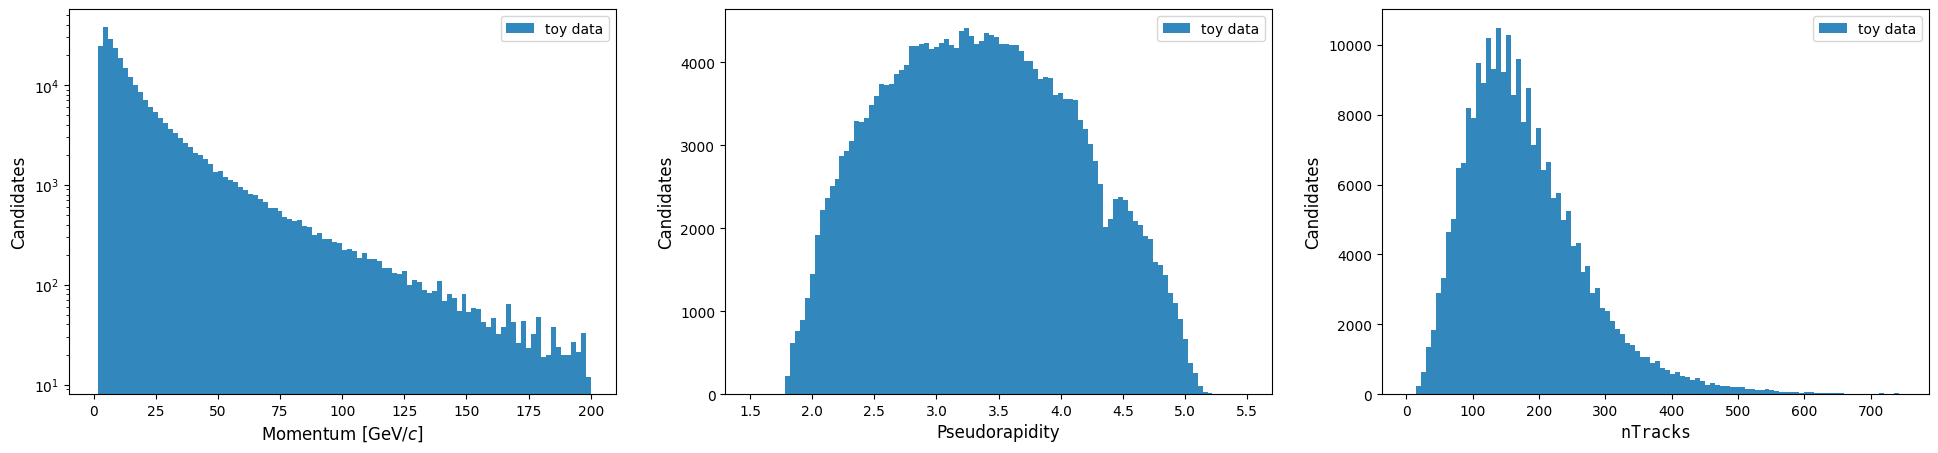

In [6]:
plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel("Momentum [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["P"]/1e3, bins=np.linspace(0.0, 200.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(1, 3, 2)
plt.xlabel("Pseudorapidity", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["ETA"], bins=np.linspace(1.5, 5.5, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 3, 3)
plt.xlabel("$\mathtt{nTracks}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["nTracks"], bins=np.linspace(0.0, 750.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

The high-level response of the RICH detectors

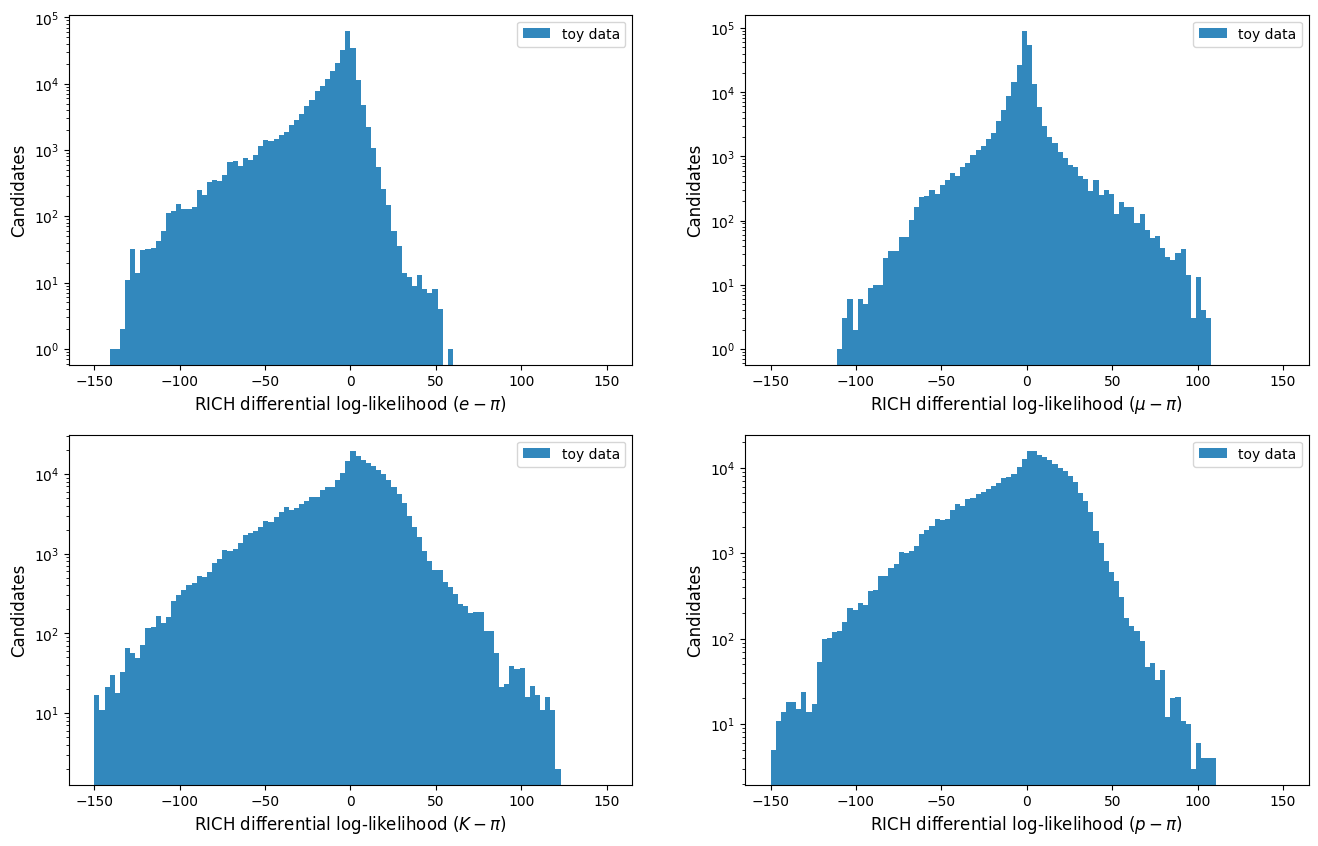

In [7]:
plt.figure(figsize=(16, 10), dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel("RICH differential log-likelihood $(e - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLe"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 2)
plt.xlabel("RICH differential log-likelihood $(\mu - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLmu"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 3)
plt.xlabel("RICH differential log-likelihood $(K - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLk"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 4)
plt.xlabel("RICH differential log-likelihood $(p - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLp"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

### Data preprocessing

In [8]:
data = shuffle(data)

x_vars = ["P", "ETA", "nTracks", "trackcharge"]
x = data[x_vars].values

y_vars = ["RichDLLe", "RichDLLmu", "RichDLLk", "RichDLLp"]
y = data[y_vars].values

x_train, x_test = x[:150000], x[150000:]
y_train, y_test = y[:150000], y[150000:]

print(f"x_train shape: {x_train.shape} \t x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}")

x_train shape: (150000, 4) 	 x_test shape: (100000, 4)
y_train shape: (150000, 4) 	 y_test shape: (100000, 4)


In [9]:
x_scaler = QuantileTransformer(output_distribution="normal")
x_train_prep = x_scaler.fit_transform(x_train[:, :3])
x_train_prep = np.c_[x_train_prep, x_train[:, 3]]

pd.DataFrame(x_train_prep, columns=x_vars).describe()

,P,ETA,nTracks,trackcharge
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,-0.021122,-0.004085,-0.005826,0.023240
std,0.984652,1.007636,1.012290,0.999733
min,-5.199338,-5.199338,-5.199338,-1.000000
25%,-0.694953,-0.689286,-0.687939,-1.000000
50%,-0.017415,-0.000646,-0.008782,1.000000
75%,0.643566,0.686387,0.678433,1.000000
max,5.199338,5.199338,5.199338,1.000000


In [10]:
y_scaler = QuantileTransformer(output_distribution="normal")
y_train_prep = y_scaler.fit_transform(y_train)

pd.DataFrame(y_train_prep, columns=y_vars).describe()

,RichDLLe,RichDLLmu,RichDLLk,RichDLLp
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,-0.009756,-0.012727,-0.003320,0.006273
std,1.009699,0.997611,0.994704,0.998654
min,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.674741,-0.675879,-0.680014,-0.660366
50%,-0.009309,-0.015256,-0.008074,-0.009407
75%,0.664213,0.665512,0.659269,0.677178
max,5.199338,5.199338,5.199338,5.199338


### Model definition

In [11]:
from pidgan.players.generators import Generator

generator = Generator(
    output_dim=y.shape[-1],
    latent_dim=64,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    dropout_rate=0.0,
    output_activation=None,
    name="generator"
)

In [12]:
_ = generator(x_train_prep[:256])
generator.summary()

Model: "generator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (256, 128)                8832      
                                                                 
 leaky_relu_0 (LeakyReLU)    (256, 128)                0         
                                                                 
 dropout_0 (Dropout)         (256, 128)                0         
                                                                 
 dense_1 (Dense)             (256, 128)                16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (256, 128)                0         
                                                                 
 dropout_1 (Dropout)         (256, 128)                0         
                                                                 
 dense_2 (Dense)             (256, 128)              

In [13]:
from pidgan.players.discriminators import Discriminator

discriminator = Discriminator(
    output_dim=1,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    dropout_rate=0.0,
    output_activation="sigmoid",
    name="discriminator"
)

In [14]:
_ = discriminator((x_train_prep[:256], y_train_prep[:256]))
discriminator.summary()

Model: "discriminator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (256, 128)                1152      
                                                                 
 leaky_relu_0 (LeakyReLU)    (256, 128)                0         
                                                                 
 dropout_0 (Dropout)         (256, 128)                0         
                                                                 
 dense_1 (Dense)             (256, 128)                16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (256, 128)                0         
                                                                 
 dropout_1 (Dropout)         (256, 128)                0         
                                                                 
 dense_2 (Dense)             (256, 128)          

In [15]:
from pidgan.algorithms import GAN

gan = GAN(
    generator=generator,
    discriminator=discriminator,
    use_original_loss=True,
    injected_noise_stddev=0.05,
    feature_matching_penalty=0.0,
    referee=None,
)

In [16]:
g_opt = keras.optimizers.RMSprop(learning_rate=0.001)
d_opt = keras.optimizers.RMSprop(learning_rate=0.0005)

In [17]:
from pidgan.metrics import Accuracy, BinaryCrossentropy

gan.compile(
    metrics=[Accuracy(), BinaryCrossentropy(from_logits=False, label_smoothing=0.0)],
    generator_optimizer=g_opt,
    discriminator_optimizer=d_opt,
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    referee_optimizer=None,
    referee_upds_per_batch=None,
)

### Training procedure

In [18]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

callbacks = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=50000,
    min_learning_rate=1e-6,
    verbose=True,
    key="g_lr",
)
callbacks.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=75000,
    min_learning_rate=1e-6,
    verbose=True,
    key="d_lr",
)
callbacks.append(d_lr_sched)

In [19]:
train = gan.fit(
    x=x_train_prep,
    y=y_train_prep,
    batch_size=256,
    epochs=100,
    validation_split=0.3,
    callbacks=callbacks,
)

Epoch 1/100
411/411 [==============================] - 24s 22ms/step - g_loss: 0.1428 - d_loss: -0.0590 - accuracy: 0.4672 - bce: 0.7637 - g_lr: 9.9685e-04 - d_lr: 0.0020 - val_g_loss: 0.0264 - val_d_loss: -0.0268 - val_accuracy: 0.5936 - val_bce: 0.7139
Epoch 2/100
411/411 [==============================] - 6s 15ms/step - g_loss: 0.0203 - d_loss: 0.0079 - accuracy: 0.5633 - bce: 0.7003 - g_lr: 9.9058e-04 - d_lr: 0.0020 - val_g_loss: 0.0035 - val_d_loss: -0.0039 - val_accuracy: 0.5352 - val_bce: 0.6997
Epoch 3/100
411/411 [==============================] - 6s 15ms/step - g_loss: 0.0108 - d_loss: 0.0079 - accuracy: 0.5217 - bce: 0.6965 - g_lr: 9.8435e-04 - d_lr: 0.0019 - val_g_loss: 0.0011 - val_d_loss: -0.0014 - val_accuracy: 0.3562 - val_bce: 0.7125
Epoch 4/100
411/411 [==============================] - 6s 14ms/step - g_loss: 0.0079 - d_loss: 0.0081 - accuracy: 0.5444 - bce: 0.6956 - g_lr: 9.7816e-04 - d_lr: 0.0019 - val_g_loss: 0.0053 - val_d_loss: -0.0052 - val_accuracy: 0.5889 - va

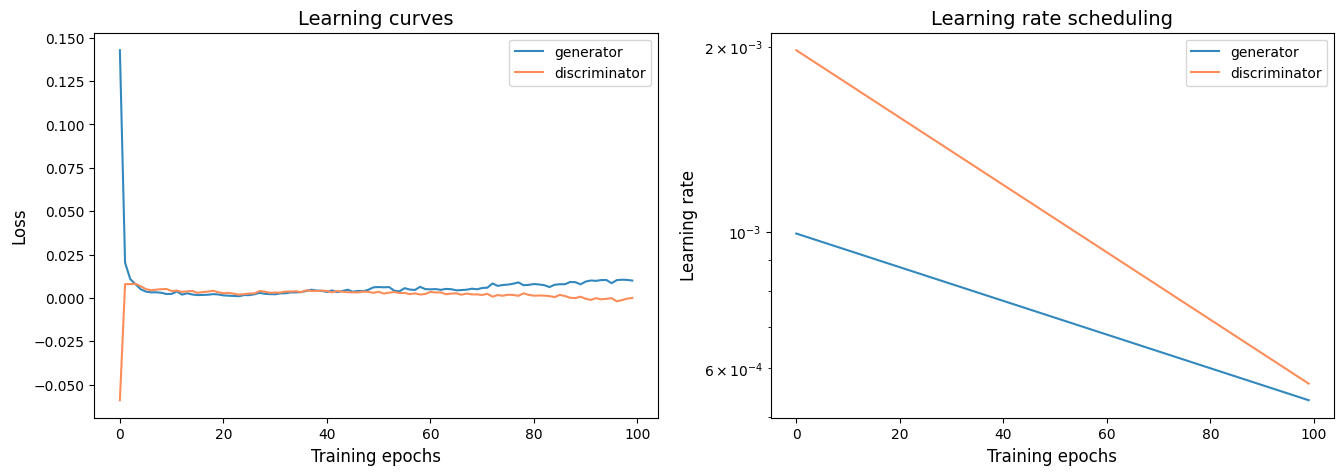

In [20]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

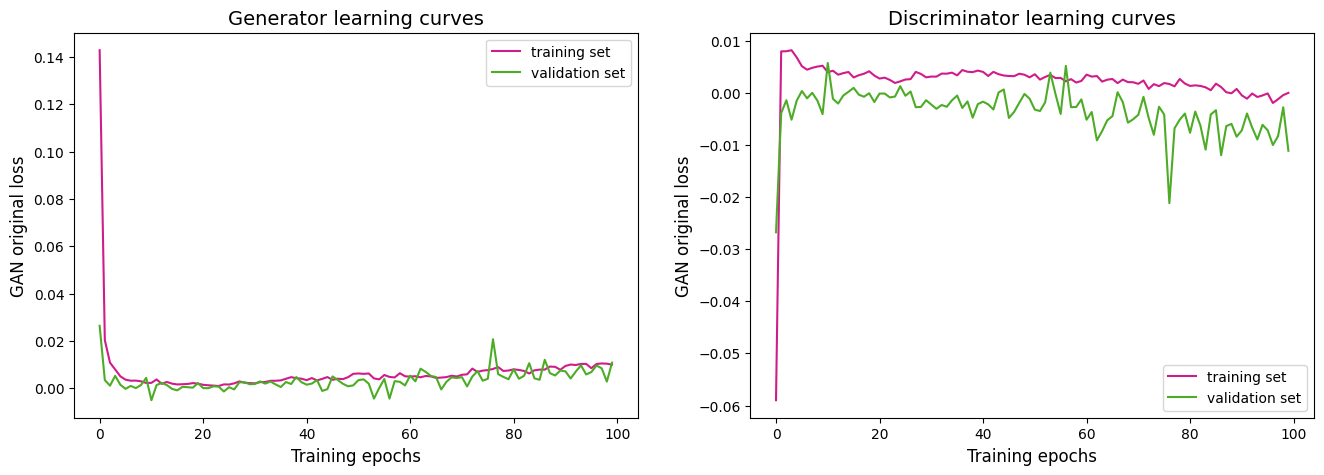

In [21]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

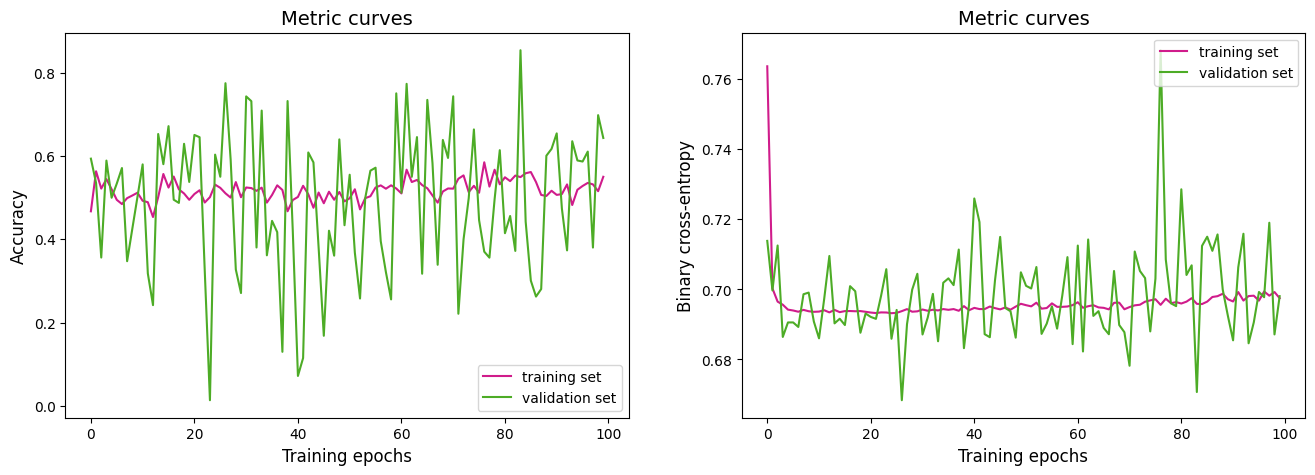

In [22]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.plot(train.history["accuracy"], color="#d01c8b", label="training set")
plt.plot(train.history["val_accuracy"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Binary cross-entropy", fontsize=12)
plt.plot(train.history["bce"], color="#d01c8b", label="training set")
plt.plot(train.history["val_bce"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.show()

### Validation plots

In [23]:
x_test_prep = x_scaler.transform(x_test[:, :3])
x_test_prep = np.c_[x_test_prep, x_test[:, 3]]

out_test = gan.generate(x_test_prep)
out_test_post = y_scaler.inverse_transform(out_test)

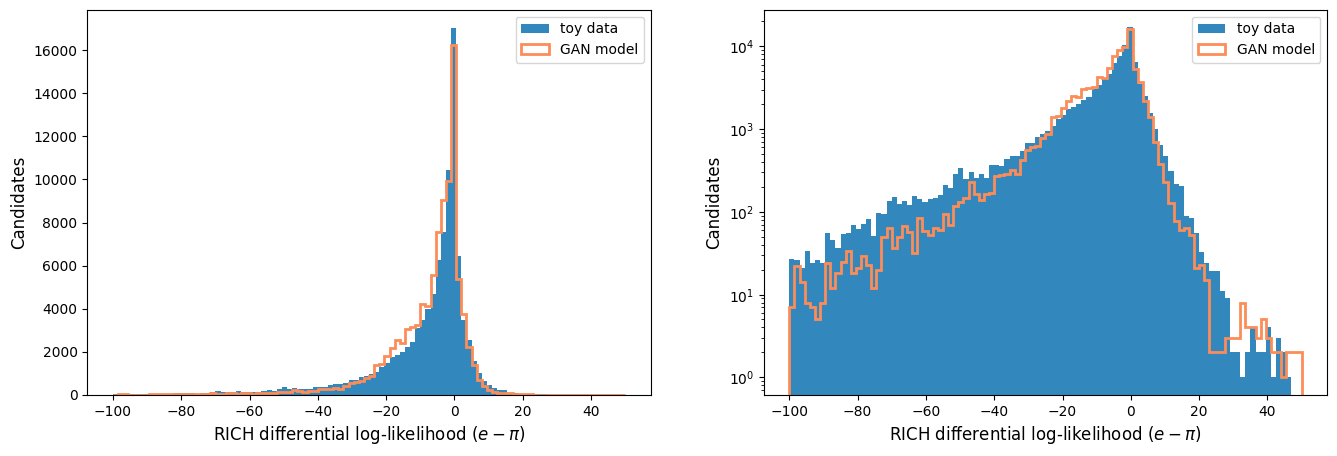

In [24]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-100.0, 50.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(e - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 0], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 0], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

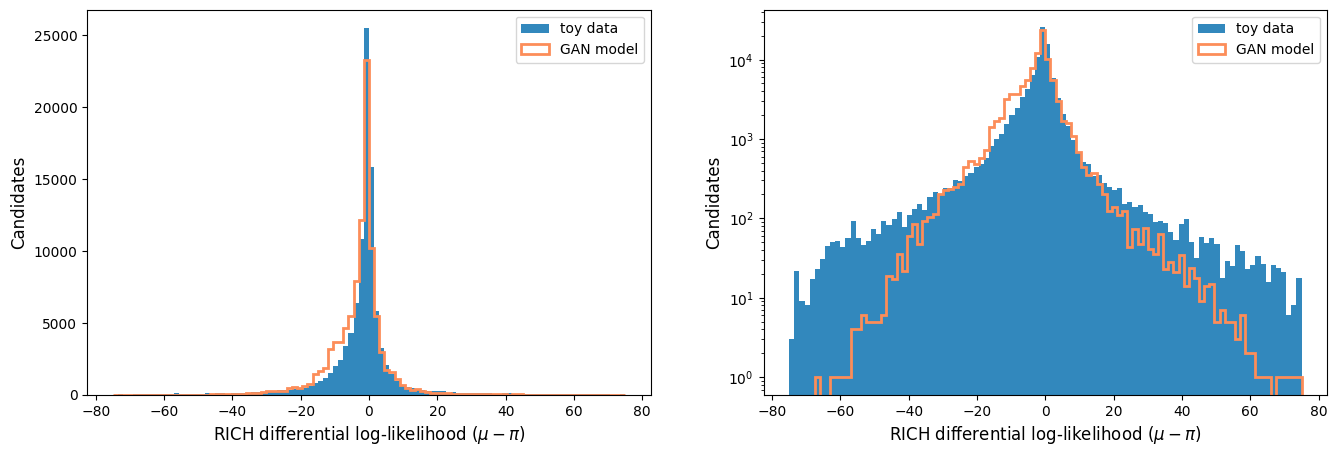

In [25]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-75.0, 75.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(\mu - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 1], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 1], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

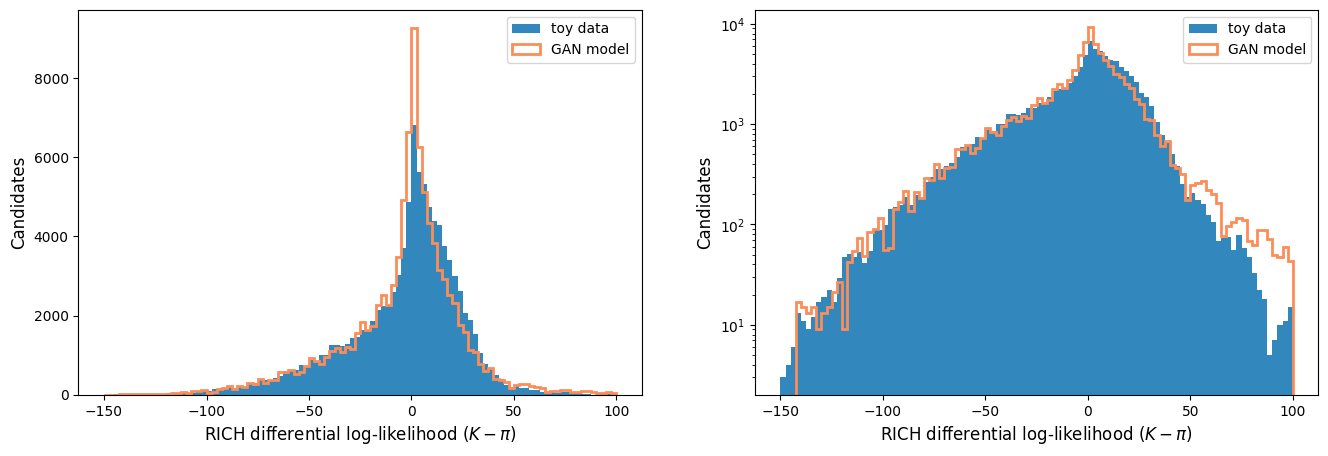

In [26]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-150.0, 100.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(K - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 2], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 2], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

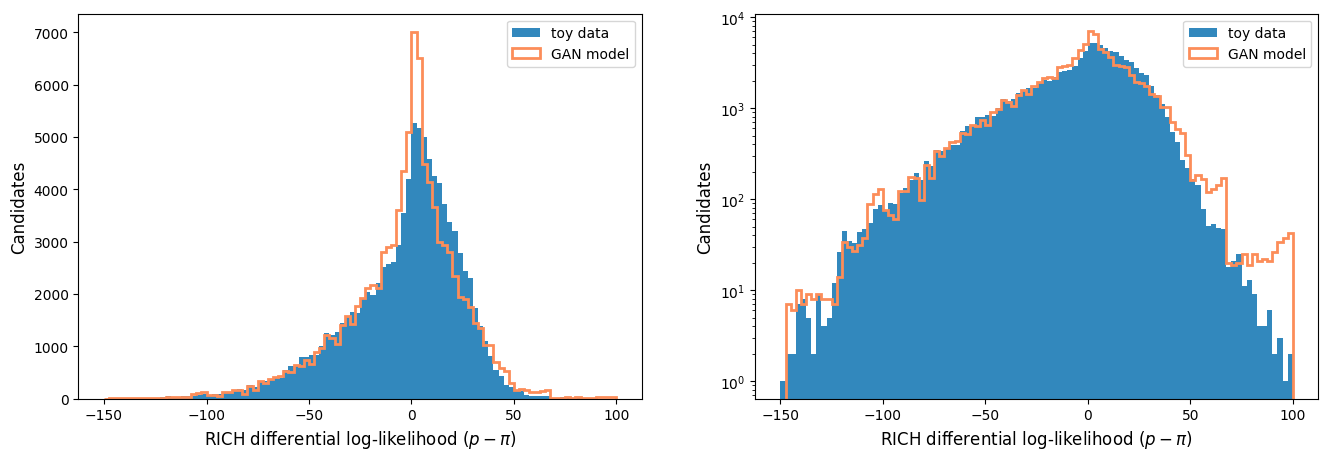

In [27]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-150.0, 100.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(p - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 3], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 3], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

### Model export

## References

1. I.J. Goodfellow _et al._, "Generative Adversarial Networks", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
2. M. Arjovsky, L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862)
3. M. Mirza, S. Osindero, "Conditional Generative Adversarial Nets", [arXiv:1411.1784](https://arxiv.org/abs/1411.1784)
4. A. Maevskiy _et al._, "Fast Data-Driven Simulation of Cherenkov Detectors Using Generative Adversarial Networks", [arXiv:1905.11825](https://arxiv.org/abs/1905.11825)
5. T. Salimans _et al._, "Improved Techniques for Training GANs", [arXiv:1606.03498](https://arxiv.org/abs/1606.03498)

## Credits
This tutorial is based on the notebooks provided by the [mbarbetti/tf-gen-models](https://github.com/mbarbetti/tf-gen-models) repository.